<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/DenseNet_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet

元論文 >> Densely Connected Convolutional Networks https://arxiv.org/abs/1608.06993 (2016)

DenseNetのブロック内の構造は、前のlayerを全てconcatしてconvする。

<img src="images/DenseNet_block.png" width=600>




# torchvision

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    model = densenet121(pretrained=True)
    del model.fc
    
    model.fc = nn.Sequential(
        nn.Linear(2048, out_dim),
    )

    return model

# scratch

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseNet(torch.nn.Module):
    def __init__(self, out_dim, densenet=121, in_height=32, in_width=32):
        super(DenseNet, self).__init__()

        self.in_height = in_height
        self.in_width = in_width

        class Block(torch.nn.Module):
            def __init__(self, first_dim, k=32, L=6):
                super(Block, self).__init__()
                self.L = L
                self.blocks = torch.nn.ModuleList()
                self.blocks.append(torch.nn.Sequential(
                        torch.nn.BatchNorm2d(first_dim),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(first_dim, k, kernel_size=1, padding=0, stride=1),
                        torch.nn.BatchNorm2d(k),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(k, k, kernel_size=3, padding=1, stride=1),
                    ))
                
                for i in range(1, L):
                    self.blocks.append(torch.nn.Sequential(
                        torch.nn.BatchNorm2d(k * i + first_dim),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(k * i + first_dim, k, kernel_size=1, padding=0, stride=1),
                        torch.nn.BatchNorm2d(k),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(k, k, kernel_size=3, padding=1, stride=1),
                    ))
                
                
            def forward(self, x):
                xs = [None for _ in range(self.L + 1)]
                xs[0] = x
                xs[1] = self.blocks[0](x)
                
                for i in range(1, self.L):
                    x_in = xs[i]
                    for j in range(i):
                        x_in = torch.cat([x_in, xs[j]], dim=1)
                    x = self.blocks[i](x_in)
                    xs[i + 1] = x
                        
                x = xs[0]
                for i in range(1, (self.L + 1)):
                    x = torch.cat([x, xs[i]], dim=1)
                return x


        if densenet == 121:
            block1_L =  6
            block2_L = 12
            block3_L = 24
            block4_L = 16
        elif densenet == 169:
            block1_L = 6
            block2_L = 12
            block3_L = 32
            block4_L = 32
        elif densenet == 201:
            block1_L = 6
            block2_L = 12
            block3_L = 48
            block4_L = 32
        elif densenet == 264:
            block1_L = 6
            block2_L = 12
            block3_L = 64
            block4_L = 48
        else:
            raise Exception(f"invalid densenet >> {densenet}")


        k = 32
        theta = 0.5
        self.bn1 = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(3, k * 2, kernel_size=7, padding=3, stride=2)

        
        # Dense block1
        block1_dim = int(k * block1_L * theta)
        
        self.block1 = Block(first_dim = k * 2, L = block1_L)
        
        # Transition layer1
        self.transition1 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(k * block1_L + k * 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(k * block1_L + k * 2, block1_dim, kernel_size=1, padding=0, stride=1),
            torch.nn.AvgPool2d(2, stride=2, padding=0)
        )
    
        # Dense block2
        block2_dim = int(k * block2_L * theta)
        
        self.block2 = Block(first_dim = block1_dim, L = block2_L)

        # Transition layer2        
        self.transition2 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(k * block2_L + block1_dim),
            torch.nn.ReLU(),
            torch.nn.Conv2d(k * block2_L + block1_dim, block2_dim, kernel_size=1, padding=0, stride=1),
            torch.nn.AvgPool2d(2, stride=2, padding=0)
        )
        
        # Dense block3
        block3_dim = int(k * block3_L * theta)
        
        self.block3 = Block(first_dim = block2_dim, L = block3_L)
        
        # Transition layer3
        self.transition3 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(k * block3_L + block2_dim),
            torch.nn.ReLU(),
            torch.nn.Conv2d(k * block3_L + block2_dim, block3_dim, kernel_size=1, padding=0, stride=1),
            torch.nn.AvgPool2d(2, stride=2, padding=0)
        )
        
        # Dense block4
        self.block4 = Block(first_dim = block3_dim, L = block4_L)
        
        self.top = torch.nn.Linear(k * block4_L + block3_dim, out_dim)
        
        
    def forward(self, x):
        # Entry flow
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv1(x)
        
        x = F.max_pool2d(x, 3, padding=1, stride=2)
        
        x = self.block1(x)
        
        x = self.transition1(x)
        
        x = self.block2(x)
        
        x = self.transition2(x)
        
        x = self.block3(x)
        
        x = self.transition3(x)
        
        x = self.block4(x)

        x = F.avg_pool2d(x, [self.in_height // 32, self.in_width // 32], padding=0, stride=1)
        x = x.view(x.size()[0], -1)
        x = self.top(x)
        
        return x

In [3]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 952kB 51.3MB/s 


# Import

In [4]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [5]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [6]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Extracting ./cifar-10-python.tar.gz to ./


In [7]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [13]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = DenseNet(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.0261 acc:0.2527  [val]loss:1.8194 acc:0.3257  [time]total:29.41sec tra:24.76sec val:4.65sec
fold:1 epoch:2/30 [tra]loss:1.9030 acc:0.3076  [val]loss:1.8024 acc:0.3414  [time]total:29.11sec tra:24.45sec val:4.65sec
fold:1 epoch:3/30 [tra]loss:1.8470 acc:0.3306  [val]loss:1.7299 acc:0.3681  [time]total:29.36sec tra:24.61sec val:4.75sec
fold:1 epoch:4/30 [tra]loss:1.8052 acc:0.3484  [val]loss:1.6382 acc:0.4100  [time]total:29.28sec tra:24.60sec val:4.68sec
fold:1 epoch:5/30 [tra]loss:1.7892 acc:0.3553  [val]loss:1.7263 acc:0.3706  [time]total:29.13sec tra:24.46sec val:4.66sec
fold:1 epoch:6/30 [tra]loss:1.7478 acc:0.3686  [val]loss:1.5894 acc:0.4190  [time]total:29.26sec tra:24.60sec val:4.66sec
fold:1 epoch:7/30 [tra]loss:1.7320 acc:0.3786  [val]loss:1.6359 acc:0.4172  [time]total:29.18sec tra:24.45sec val:4.73sec
fold:1 epoch:8/30 [tra]loss:1.7082 acc:0.3833  [val]loss:1.6109 acc:0.4335  [time]total:29.66s

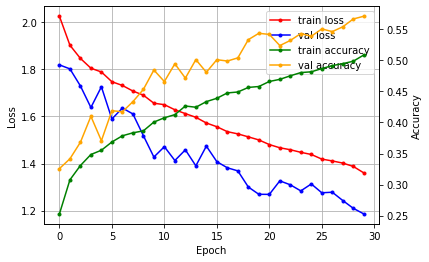

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.0412 acc:0.2394  [val]loss:1.9653 acc:0.2920  [time]total:29.04sec tra:24.34sec val:4.70sec
fold:2 epoch:2/30 [tra]loss:1.9096 acc:0.2992  [val]loss:1.8490 acc:0.3293  [time]total:29.17sec tra:24.45sec val:4.72sec
fold:2 epoch:3/30 [tra]loss:1.8494 acc:0.3222  [val]loss:1.7230 acc:0.3842  [time]total:29.22sec tra:24.60sec val:4.62sec
fold:2 epoch:4/30 [tra]loss:1.8074 acc:0.3422  [val]loss:1.7484 acc:0.3736  [time]total:29.29sec tra:24.56sec val:4.73sec
fold:2 epoch:5/30 [tra]loss:1.7771 acc:0.3576  [val]loss:1.7139 acc:0.3817  [time]total:29.64sec tra:24.96sec val:4.68sec
fold:2 epoch:6/30 [tra]loss:1.7612 acc:0.3608  [val]loss:1.7340 acc:0.3908  [time]total:29.15sec tra:24.47sec val:4.67sec
fold:2 epoch:7/30 [tra]loss:1.7222 acc:0.3745  [val]loss:1.6383 acc:0.4123  [time]total:29.09sec tra:24.47sec val:4.62sec
fold:2 epoch:8/30 [tra]loss:1.7109 acc:0.3822  [val]loss:1.5514 acc:0.4327  [time]total:29.11s

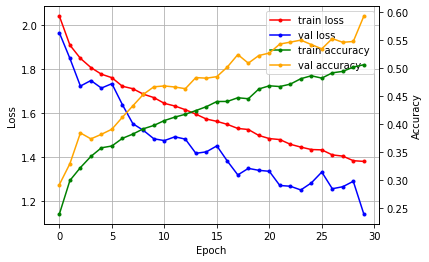

all folds score
total loss:1.163169, accuracy:0.581960
fold1/2 loss:1.185897, accuracy:0.571160
fold2/2 loss:1.140442, accuracy:0.592760

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,3489,194,261,99,98,66,30,84,493,186
1,235,3582,50,73,22,74,58,88,177,641
2,535,145,2304,316,503,362,335,295,130,75
3,149,118,321,1856,322,1150,431,280,142,231
4,194,27,630,344,2337,313,402,600,88,65
5,102,99,218,1157,272,2358,157,378,136,123
6,40,92,270,352,267,269,3527,72,50,61
7,166,68,203,374,412,491,46,3002,51,187
8,553,322,81,100,46,86,25,43,3496,248


In [16]:
train_models, train_model_paths = train()

# Test

In [17]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.6185 (6185 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,734,28,53,12,15,12,6,15,102,23
1,40,750,3,10,2,17,9,12,31,126
2,122,30,463,55,111,67,66,52,24,10
3,21,22,55,382,72,250,82,52,29,35
4,33,8,107,56,524,62,76,111,14,9
5,19,16,35,207,36,552,31,61,25,18
6,6,15,54,52,53,45,744,13,9,9
7,36,6,44,50,53,106,10,644,10,41
8,108,61,16,18,7,14,4,11,713,48
